# Méthode de plus forte pente

Considérons $f \in C^1$. Le méthode de plus forte pente consiste à calculer itérativement
$$
x_{k+1} = x_k - \alpha^* \nabla f(x^k)
$$
où $\alpha^* \in \arg\min_{\alpha \geq 0} f(x_k - \alpha \nabla f(x_k))$.

In [1]:
using Optim
using Plots

Nous avons besoin de la librairie `LinearAlgebra` pour accéder à des méthodes comme `det`, qui calcul le déterminant d'une matrice.

In [2]:
using LinearAlgebra

## Exemple 1

Considérons la fonction bivariée
$$
f(x, y) = 4x^2 - 4xy + 2y^2
$$

In [3]:
# plotly()

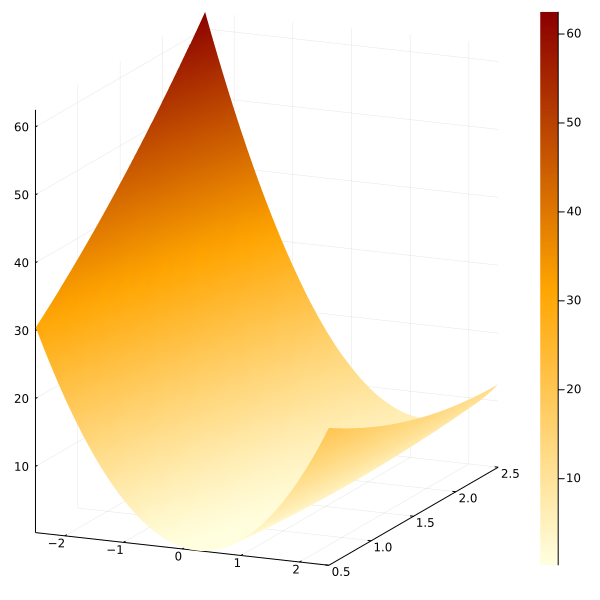

In [4]:
f1(x) = 4x[1]*(x[1]-x[2])+2*x[2]*x[2]

default(size=(600,600), fc=:heat)
x, y = -2.5:0.1:2.5, 0.5:0.1:2.5
z = Surface((x,y)->f1([x,y]), x, y)
surface(x,y,z)

Son gradient est
$$
\nabla f(x, y) = \begin{pmatrix} 8x - 4y \\ 4y - 4x \end{pmatrix}
$$
La matrice hessienne est
$$
\nabla f^2(x,y) =
\begin{pmatrix}
8 & -4 \\ -4 & 4
\end{pmatrix}
$$

In [5]:
A = [8 -4; -4 4 ]

2×2 Matrix{Int64}:
  8  -4
 -4   4

Les déterminants des mineurs principaux sont

In [6]:
8
det( A )

16.0

Dès lors, la matrice est définie positive. Nous pouvons le confirmer en calculant ses valeurs propres:

In [7]:
eigvals(A)

2-element Vector{Float64}:
  1.5278640450004206
 10.47213595499958

Nous calculons le gradient comme

In [8]:
function f1grad(x)
    return [8*x[1]-4*x[2], 4*x[2]-4*x[1]]
end

f1grad (generic function with 1 method)

Considérons $x_0 = (2, 3)$. Dès lors $\nabla f(x_0) = (4, 4)$.

Nous devons minimiser la fonction univariée
$$
m(\alpha) = f((2, 3) - \alpha(4, 4)) = f(2 - 4\alpha, 3 - 4\alpha)
$$
La dérivée de $m(\alpha)$ est
\begin{align*}
m'(\alpha) &= \nabla_{(x,y)} f(2 - 4\alpha, 3 - 4\alpha)^T \nabla_{\alpha} \begin{pmatrix} 2 - 4\alpha \\ 3 - 4\alpha \end{pmatrix} \\
&= \begin{pmatrix} 8(2-4\alpha) - 4(3-4\alpha) & 4(3-4\alpha) - 4(2-4\alpha)\end{pmatrix}\begin{pmatrix} -4 \\ -4 \end{pmatrix} \\
&= -\begin{pmatrix} 4 - 16\alpha & 4\end{pmatrix}\begin{pmatrix} 4 \\ 4 \end{pmatrix} \\
&= -16+64\alpha-16\\
&= 64\alpha-32
\end{align*}

La dérivée seconde de $m(\alpha)$ est
$$
m''(\alpha) = 64
$$
Le modèle unidimensionel est dès lors strictement convexe. Le minimiseur peut être trouvé en posant $m'(\alpha^*) = 0$, menant à $\alpha^* = \frac{1}{2}$. Ainsi,
$$
x_1 = x_0 - \frac{1}{2}\nabla f(x_0) = (2, 3) - \frac{1}{2}(4, 4) = (0, 1),
$$
et
$$
\nabla f(x_1) = \begin{pmatrix} -4 \\ 4 \end{pmatrix}
$$
La fonction univariée à minimiser est à présent
$$
m(\alpha) = f((0, 1) - \alpha(-4, 4)) = f(4\alpha, 1 - 4\alpha)
$$
et sa dérivée est
\begin{align*}
m'(\alpha) &= \nabla_{(x,y)} f(4\alpha, 1 - 4\alpha)^T \nabla_{\alpha} \begin{pmatrix} 4\alpha \\ 1 - 4\alpha \end{pmatrix} \\
&= ( 8 \times 4\alpha - 4(1-4\alpha), 4(1-4\alpha) - 4\times(4\alpha))\begin{pmatrix} 4 \\ -4 \end{pmatrix} \\
&= ( -4 + 48\alpha, 4 - 32 \alpha)\begin{pmatrix} 4 \\ -4 \end{pmatrix} \\
&= -32+320\alpha
\end{align*}
La racine de $m'(\alpha)$ est $\alpha^* = \frac{1}{10}$, et $m''(\alpha) = 320$, aussi $\alpha^*$ est un minimiseur global.
Nous obtenons
$$
x_2 = \begin{pmatrix} 0 \\ 1 \end{pmatrix} - \frac{1}{10}\begin{pmatrix} -4 \\ 4 \end{pmatrix}
= \begin{pmatrix} \frac{4}{10} \\ \frac{6}{10} \end{pmatrix}
= \begin{pmatrix} \frac{2}{5} \\ \frac{3}{5} \end{pmatrix}
$$
Nous pourrions continuer, mais un tel calcul à la main est fastidieux. Nous allons automatiser la procédure en construisant une fonction Julia.

In [9]:
function steepestdescent(f::Function, fprime::Function, x0, h::Float64, verbose::Bool = true,
                         record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end
    
    while ((k < maxiter) && (norm(grad) > tol))
        α = Optim.minimizer(optimize(fsearch, 0, h, GoldenSection()))
        x = x-α*grad
        k += 1
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx")
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

steepestdescent (generic function with 5 methods)

La variante suivante propose d'élargir l'intervalle dans lequel a lieu la recherche unidimensionnelle quand la borne supérieur est atteinte.

Ce n'est valable que pour des fonctions convexes!

L'idée sera généralisée lors de la discussion sur les régions de confiance.

In [10]:
function steepestdescent_convex(f::Function, fprime::Function, x0, h::Float64, verbose::Bool = true,
        record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end

    Δ = 1e-6
    
    while ((k < maxiter) && (norm(grad) > tol))
        α = Optim.minimizer(optimize(fsearch, 0, h, GoldenSection()))
        while ((h-α) <= Δ)
            h *= 2
            α = Optim.minimizer(optimize(fsearch, α, h, GoldenSection()))
        end
        h = α
        x = x-α*grad
        k += 1
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx")
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

steepestdescent_convex (generic function with 5 methods)

L'exécution de cette fonction donne

In [11]:
sol, iter = steepestdescent(f1, f1grad, [2.0,3.0], 2.0, true, true)

0. x = [2.0, 3.0], f([2.0, 3.0]) = 10.0
1. x = [3.3384826014781765e-9, 1.0000000033384826], f([3.3384826014781765e-9, 1.0000000033384826]) = 2.0
2. x = [0.4000000056568157, 0.5999999996847565], f([0.4000000056568157, 0.5999999996847565]) = 0.4000000042732578
3. x = [1.2686234840408872e-8, 0.20000004191604126], f([1.2686234840408872e-8, 0.20000004191604126]) = 0.08000002338384717
4. x = [0.08000002003440877, 0.12000002949337335], f([0.08000002003440877, 0.12000002949337335]) = 0.01600000792444612
5. x = [1.2797865406311004e-9, 0.04000001297171028], f([1.2797865406311004e-9, 0.04000001297171028]) = 0.003200001870708075
6. x = [0.016000005590790508, 0.024000008148791697], f([0.016000005590790508, 0.024000008148791697]) = 0.0006400004396667061
7. x = [4.5701057174718507e-10, 0.008000003964587964], f([4.5701057174718507e-10, 0.008000003964587964]) = 0.00012800011224250156
8. x = [0.0032000017064671205, 0.004800002532327185], f([0.0032000017064671205, 0.004800002532327185]) = 2.5600027128290

([8.192019638207948e-9, 1.2288029327965716e-8], [10.0 2.0 3.0; 2.0 3.3384826014781765e-9 1.0000000033384826; … ; 8.388647356522391e-16 5.772500948176087e-16 2.048004861982361e-8; 1.677729622627484e-16 8.192019638207948e-9 1.2288029327965716e-8])

In [12]:
sol, iter = steepestdescent(f1, f1grad, [10.0,10.0], 2.0, true, true)

0. x = [10.0, 10.0], f([10.0, 10.0]) = 200.0
1. x = [5.000000000465118, 10.0], f([5.000000000465118, 10.0]) = 100.0
2. x = [4.999999999534882, 4.9999999754264985], f([4.999999999534882, 4.9999999754264985]) = 49.999999990697646
3. x = [2.499999987945808, 4.99999998748069], f([2.499999987945808, 4.99999998748069]) = 24.9999998748069
4. x = [2.499999999534882, 2.4999999754264985], f([2.499999999534882, 2.4999999754264985]) = 12.49999999534882
5. x = [1.2499999878295287, 2.49999998748069], f([1.2499999878295287, 2.49999998748069]) = 6.24999993740345
6. x = [1.2499999996511608, 1.2500000252711772], f([1.2499999996511608, 1.2500000252711772]) = 3.1249999982558054
7. x = [0.6249999960013161, 1.2500000124611685], f([0.6249999960013161, 1.2500000124611685]) = 1.562500031152922
8. x = [0.6250000164598511, 0.6250000365727931], f([0.6250000164598511, 0.6250000365727931]) = 0.7812500411496293
9. x = [0.3125000099692602, 0.6250000265163219], f([0.3125000099692602, 0.6250000265163219]) = 0.390625033

([1.862646628163515e-8, 3.725293376026287e-8], [200.0 10.0 10.0; 100.0 5.000000000465118 10.0; … ; 2.7755619382292965e-15 3.7252932355918514e-8 3.7252935164607425e-8; 1.3877810737465348e-15 1.862646628163515e-8 3.725293376026287e-8])

In [13]:
sol, iter = steepestdescent(f1, f1grad, [100.0,100.0], 2.0, true, true)

0. x = [100.0, 100.0], f([100.0, 100.0]) = 20000.0
1. x = [50.00000000465118, 100.0], f([50.00000000465118, 100.0]) = 10000.0
2. x = [49.99999999534882, 49.99999975426499], f([49.99999999534882, 49.99999975426499]) = 4999.999999069764
3. x = [24.999999879458084, 49.9999998748069], f([24.999999879458084, 49.9999998748069]) = 2499.9999874806904
4. x = [24.99999999534882, 24.99999975426499], f([24.99999999534882, 24.99999975426499]) = 1249.9999995348821
5. x = [12.49999987829529, 24.999999874806903], f([12.49999987829529, 24.999999874806903]) = 624.9999937403452
6. x = [12.49999999651161, 12.500000252711775], f([12.49999999651161, 12.500000252711775]) = 312.49999982558063
7. x = [6.249999960013162, 12.50000012461169], f([6.249999960013162, 12.50000012461169]) = 156.2500031152923
8. x = [6.250000164598514, 6.250000365727932], f([6.250000164598514, 6.250000365727932]) = 78.125004114963
9. x = [3.1250000996926026, 6.25000026516322], f([3.1250000996926026, 6.25000026516322]) = 39.062503314540

([2.3283061655662933e-8, 4.656612314936741e-8], [20000.0 100.0 100.0; 10000.0 50.00000000465118 100.0; … ; 4.3368077641337195e-15 4.656612376037819e-8 4.656612253835665e-8; 2.1684038251620514e-15 2.3283061655662933e-8 4.656612314936741e-8])

Nous convergeons vers la solution $(0,0)$, mais la méthode est très lente près de la solution.

In [14]:
sol, iter = steepestdescent(f1, f1grad, [2.0,3.0], 0.1, true, true)

0. x = [2.0, 3.0], f([2.0, 3.0]) = 10.0
1. x = [1.6000000074048677, 2.6000000074048675], f([1.6000000074048677, 2.6000000074048675]) = 7.120000047391152
2. x = [1.3600000088858413, 2.2000000148097354], f([1.3600000088858413, 2.2000000148097354]) = 5.110400068243261
3. x = [1.1520000115515936, 1.8640000186602665], f([1.1520000115515936, 1.8640000186602665]) = 3.6680960734752444
4. x = [0.9760000130325671, 1.579200021089063], f([0.9760000130325671, 1.579200021089063]) = 2.632852550317856
5. x = [0.8268800138026734, 1.337920022333081], f([0.8268800138026734, 1.337920022333081]) = 1.8897848950901366
6. x = [0.7005440140325205, 1.1335040227051016], f([0.7005440140325205, 1.1335040227051016]) = 1.3564325694131156
7. x = [0.593510413869969, 0.9603200224420807], f([0.593510413869969, 0.9603200224420807]) = 0.9736078006258554
8. x = [0.5028300934295156, 0.8135961817294126], f([0.5028300934295156, 0.8135961817294126]) = 0.6988273289911094
9. x = [0.4260044927998767, 0.6892897487106355], f([0.426

82. x = [2.359919470410276e-6, 3.818429913836477e-6], f([2.359919470410276e-6, 3.818429913836477e-6]) = 1.539294524080962e-11
83. x = [1.9993558662914607e-6, 3.2350257472660737e-6], f([1.9993558662914607e-6, 3.2350257472660737e-6]) = 1.1048607869643784e-11
84. x = [1.6938814778197153e-6, 2.7407578040262003e-6], f([1.6938814778197153e-6, 2.7407578040262003e-6]) = 7.930369006544579e-12
85. x = [1.4350794219654107e-6, 2.322007281295587e-6], f([1.4350794219654107e-6, 2.322007281295587e-6]) = 5.692187950009173e-12
86. x = [1.2158188009703066e-6, 1.9672361441310998e-6], f([1.2158188009703066e-6, 1.9672361441310998e-6]) = 4.0856867607913985e-12
87. x = [1.0300582212853326e-6, 1.6666692124309284e-6], f([1.0300582212853326e-6, 1.6666692124309284e-6]) = 2.932586986569762e-12
88. x = [8.726793321428626e-7, 1.4120248206867102e-6], f([8.726793321428626e-7, 1.4120248206867102e-6]) = 2.104925545523829e-12
89. x = [7.393457971715496e-7, 1.196286629262953e-6], f([7.393457971715496e-7, 1.196286629262953

([3.1674739210844834e-8, 5.125080462793596e-8], [10.0 2.0 3.0; 7.120000047391152 1.6000000074048677 2.6000000074048675; … ; 3.86338169357254e-15 3.738695799187142e-8 6.049336876681246e-8; 2.773022882578525e-15 3.1674739210844834e-8 5.125080462793596e-8])

In [15]:
sol, iter = steepestdescent_convex(f1, f1grad, [2.0,3.0], 0.1, true, true)

0. x = [2.0, 3.0], f([2.0, 3.0]) = 10.0
1. x = [-6.864689705565752e-9, 0.9999999931353103], f([-6.864689705565752e-9, 0.9999999931353103]) = 2.0
2. x = [0.39999999550607185, 0.5999999935104245], f([0.39999999550607185, 0.5999999935104245]) = 0.3999999912131972
3. x = [-4.951900556271482e-10, 0.19999999650389555], f([-4.951900556271482e-10, 0.19999999650389555]) = 0.0799999975992685
4. x = [0.07999999835247451, 0.11999999785430701], f([0.07999999835247451, 0.11999999785430701]) = 0.015999999393085048
5. x = [-6.581302169905712e-10, 0.03999999754132129], f([-6.581302169905712e-10, 0.03999999754132129]) = 0.0031999997119122486
6. x = [0.015999998860773402, 0.023999998285669757], f([0.015999998860773402, 0.023999998285669757]) = 0.0006399999086861844
7. x = [-4.1769140229908075e-11, 0.007999999405088599], f([-4.1769140229908075e-11, 0.007999999405088599]) = 0.00012799998229944828
8. x = [0.0031999997458548846, 0.00479999963417223], f([0.0031999997458548846, 0.00479999963417223]) = 2.559999

([8.192001380727594e-9, 1.228800200709067e-8], [10.0 2.0 3.0; 2.0 -6.864689705565752e-9 0.9999999931353103; … ; 8.388607278346872e-16 2.667964187437204e-15 2.0480001787039767e-8; 1.6777221550601903e-16 8.192001380727594e-9 1.228800200709067e-8])

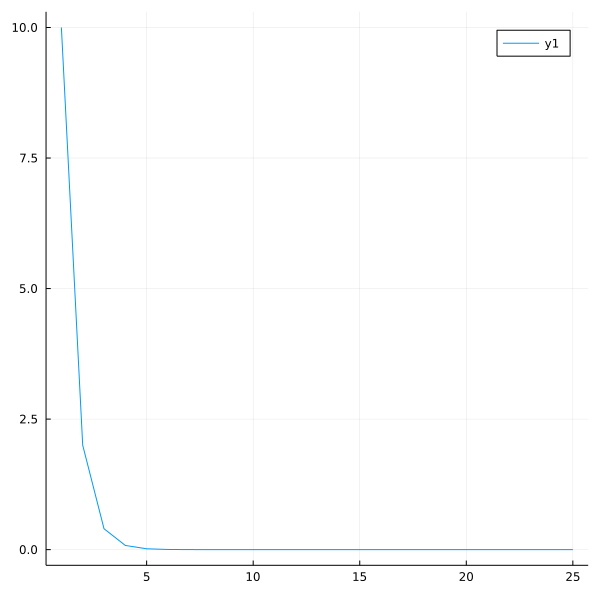

In [16]:
k = [x = i for i=1:length(iter[:,1])]
Plots.plot(k,iter[:,1])

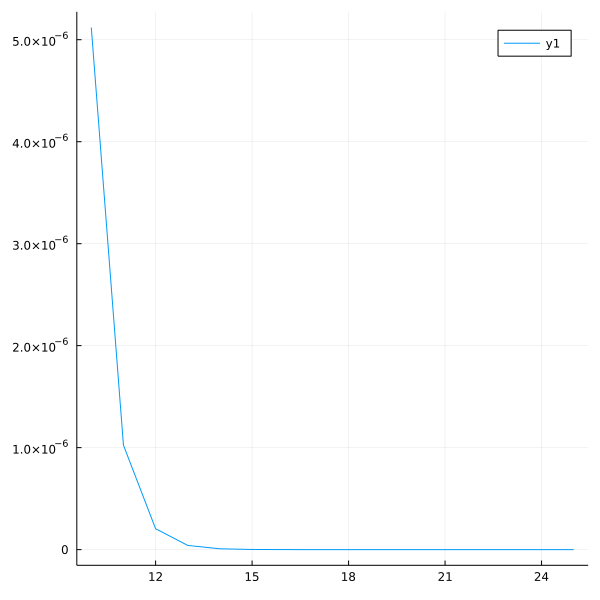

In [17]:
k = [x = i for i=10:length(iter[:,1])]
Plots.plot(k,iter[10:length(iter[:,1]),1])

## Descente par coordonnée (Coordinate descent)

In [18]:
function GaussSeidel(f::Function, x0, h::Float64, verbose::Bool = true, δ::Float64 = 1e-6, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x+α*d))
    end

    x = copy(x0)
    n = length(x)
    k = 0
    d = zeros(n)
    
    while true
        x0[:] = x[:]
        k += 1
        
        for i = 1:n
            d[i] = 1.0  # d is now the i^th vector of the canonical basis
            α = Optim.minimizer(optimize(fsearch, -h, h, GoldenSection()))
            x[i] += α
            d[i] = 0.0
        end
        
        if verbose
            println(k, ". ", f(x), " ", x, " ", x0)
        end
        
        if norm(x-x0) < δ
            break
        end
    end
    
    return x
end

GaussSeidel (generic function with 4 methods)

In [19]:
function Jacobi(f::Function, x0, h::Float64, verbose::Bool = true, δ::Float64 = 1e-6, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x0+α*d))
    end

    x = copy(x0)
    n = length(x)
    k = 0
    d = zeros(n)
    α = zeros(n)
    
    while true
        x0[:] = x[:]
        k += 1
        
        for i = 1:n
            d[i] = 1.0  # d is now the i^th vector of the canonical basis
            α[i] = Optim.minimizer(optimize(fsearch, -h, h, GoldenSection()))
            d[i] = 0.0
        end
        x += α
        
        if verbose
            println(k, ". ", f(x), " ", x, " ", x0)
        end
        
        if norm(x-x0) < δ
            break
        end
    end
    
    return x
end

Jacobi (generic function with 4 methods)

In [20]:
sol = GaussSeidel(f1, [2.0,3.0], 1.0)

1. 5.000000077387162 [1.5000000079056401, 2.0000000228822996] [2.0, 3.0]
2. 2.0000000632451234 [1.0000000158112803, 1.0000000457645992] [1.5000000079056401, 2.0000000228822996]
3. 0.5000000474338421 [0.5000000237169204, 0.5000000307879399] [1.0000000158112803, 1.0000000457645992]
4. 0.12500001539397046 [0.25000001539397, 0.25000001706321123] [0.5000000237169204, 0.5000000307879399]
5. 0.03125000416728935 [0.12500000833457842, 0.1250000087286328] [0.25000001539397, 0.25000001706321123]
6. 0.007812501151963877 [0.06250000460785533, 0.06250000372672286] [0.12500000833457842, 0.1250000087286328]
7. 0.0019531252199197183 [0.031250001759357694, 0.031250001666334036] [0.06250000460785533, 0.06250000372672286]
8. 0.0004882813042936666 [0.01562500086869864, 0.015625001076705763] [0.031250001759357694, 0.031250001666334036]
9. 0.00012207032898039452 [0.007812500527372607, 0.007812500549332475] [0.01562500086869864, 0.015625001076705763]
10. 3.05175820735303e-5 [0.003906250252705931, 0.0039062502

2-element Vector{Float64}:
 4.768371704395399e-7
 4.768371742085676e-7

In [21]:
sol = Jacobi(f1, [2.0,3.0], 1.0)

1. 5.000000077387162 [1.5000000079056401, 2.0000000228822996] [2.0, 3.0]
2. 2.5000000474338413 [1.0000000158112803, 1.5000000079056401] [1.5000000079056401, 2.0000000228822996]
3. 1.250000019984384 [0.7500000020865516, 1.0000000158112803] [1.0000000158112803, 1.5000000079056401]
4. 0.6250000045904134 [0.5000000025038618, 0.7500000020865516] [0.7500000020865516, 1.0000000158112803]
5. 0.3124999987596968 [0.37499999750776586, 0.5000000025038618] [0.5000000025038618, 0.7500000020865516]
6. 0.1562499993798483 [0.2500000012519306, 0.37499999750776586] [0.37499999750776586, 0.5000000025038618]
7. 0.07812500010723425 [0.1874999995885032, 0.2500000012519306] [0.2500000012519306, 0.37499999750776586]
8. 0.03906249989421866 [0.12499999998837143, 0.1874999995885032] [0.1874999995885032, 0.2500000012519306]
9. 0.019531249996365997 [0.09374999999127827, 0.12499999998837143] [0.12499999998837143, 0.1874999995885032]
10. 0.009765624937298168 [0.06249999999418511, 0.09374999950420024] [0.0937499999912

2-element Vector{Float64}:
 9.536743081581584e-7
 1.4305115337047087e-6

## Exemple 2

Considérons la fonction bivariée
$$
f(x,y) = \frac{(2-x)^2}{2y^2}+\frac{(3-x)^2}{2y^2} + \ln y
$$
qui est calculée de Julia comme

In [22]:
f(x) = (2-x[1])*(2-x[1])/(2*x[2]*x[2])+(3-x[1])*(3-x[1])/(2*x[2]*x[2])+log(x[2])

f (generic function with 1 method)

Sa dérivée est
$$
\nabla f(x) =
\begin{pmatrix}
\frac{-2(2-x)}{2y^2}+\frac{-2(3-x)}{2y^2} \\
-\frac{(2-x)^2}{y^3}-\frac{(3-x)^2}{y^3} + \frac{1}{y}
\end{pmatrix} =
\begin{pmatrix}
\frac{x-2}{y^2}+\frac{x-3}{y^2} \\
-\frac{(2-x)^2}{y^3}-\frac{(3-x)^2}{y^3} + \frac{1}{y}
\end{pmatrix}
$$

In [23]:
function fprime(x)
    return [(x[1]-2)/(x[2]*x[2])+(x[1]-3)/(x[2]*x[2]),
            -(2-x[1])*(2-x[1])/(x[2]*x[2]*x[2])-(3-x[1])*(3-x[1])/(x[2]*x[2]*x[2])+1/x[2]]
end

fprime (generic function with 1 method)

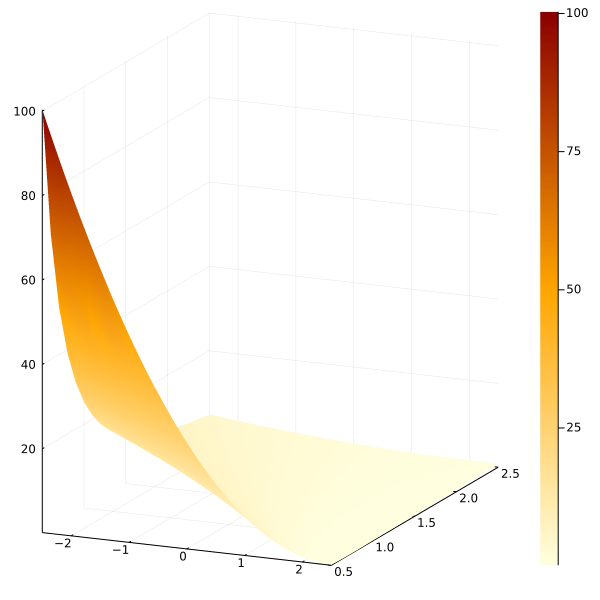

In [24]:
default(size=(600,600), fc=:heat)
x, y = -2.5:0.1:2.5, 0.5:0.1:2.5
z = Surface((x,y)->f([x,y]), x, y)
surface(x,y,z, linealpha = 0.3)

In [25]:
sol = steepestdescent(f, fprime, [1.0,1.0], 2.0)

0. x = [1.0, 1.0], f([1.0, 1.0]) = 2.5
1. x = [1.7372587860329785, 1.983011714710638], f([1.7372587860329785, 1.983011714710638]) = 0.896138426032156
2. x = [2.513124637228901, 1.4011123268707641], f([2.513124637228901, 1.4011123268707641]) = 0.46470276486893225
3. x = [2.4956787822266584, 0.7072418427364364], f([2.4956787822266584, 0.7072418427364364]) = 0.1534637777752843
4. x = [2.5000006651034723, 0.7071331798184928], f([2.5000006651034723, 0.7071331798184928]) = 0.15342641111460076
5. x = [2.500000000087787, 0.7071067851642167], f([2.500000000087787, 0.7071067851642167]) = 0.1534264097200273


2-element Vector{Float64}:
 2.500000000087787
 0.7071067851642167

Le choix de $h$ est important. Considérons par exemple une valeur trop petite: $h = 0.1$.

In [26]:
sol = steepestdescent(f, fprime, [1.0,1.0], 0.1)

0. x = [1.0, 1.0], f([1.0, 1.0]) = 2.5
1. x = [1.2999999944463494, 1.3999999925951323], f([1.2999999944463494, 1.3999999925951323]) = 1.1987171452127503
2. x = [1.4224489736334012, 1.4517492653223856], f([1.4224489736334012, 1.4517492653223856]) = 1.0423138817560311
3. x = [1.5247039853182156, 1.475106557585013], f([1.5247039853182156, 1.475106557585013]) = 0.940768737862173
4. x = [1.6143476597923594, 1.4821621166588037], f([1.6143476597923594, 1.4821621166588037]) = 0.864358580139489
5. x = [1.694978622416709, 1.4782295737415783], f([1.694978622416709, 1.4782295737415783]) = 0.8018257158146598
6. x = [1.7686593028295523, 1.4661855148379586], f([1.7686593028295523, 1.4661855148379586]) = 0.7477658887565877
7. x = [1.8367004895910684, 1.447784262370351], f([1.8367004895910684, 1.447784262370351]) = 0.6992042102917204
8. x = [1.8999900328356423, 1.4241854315536886], f([1.8999900328356423, 1.4241854315536886]) = 0.6543497716383153
9. x = [1.9591537394222065, 1.396204489808551], f([1.9591

2-element Vector{Float64}:
 2.499999993738345
 0.7071068003129874

Un trop grand $h$ peut également conduire à des difficultés. Considérons par exemple $h = 10$.

In [27]:
sol = steepestdescent(f, fprime, [1.0,1.0], 10.0)

0. x = [1.0, 1.0], f([1.0, 1.0]) = 2.5
1. x = [1.7372587898585392, 1.9830117198113857], f([1.7372587898585392, 1.9830117198113857]) = 0.8961384260321561
2. x = [2.7600511664670666, 1.2159174254290082], f([2.7600511664670666, 1.2159174254290082]) = 0.4103356935877639


LoadError: DomainError with -0.5756950722227869:
log will only return a complex result if called with a complex argument. Try log(Complex(x)).

Nous devrons nous assurer que les itérés garantissent que $y > 0$ en raison de l'opérateur logarithmique.

Le choix du point de départ est également important afin de s'assurer que l'algorithme converge assez rapidement. Considérons par exemple $x_0 = (0.1, 0.1)$.

In [28]:
sol = steepestdescent(f, fprime, [0.1,0.1], 2.0)

0. x = [0.1, 0.1], f([0.1, 0.1]) = 598.6974149070059
1. x = [0.23100162549763276, 3.3777698379720196], f([0.23100162549763276, 3.3777698379720196]) = 1.6903682722194482
2. x = [1.0264904108324768, 3.3459767803698806], f([1.0264904108324768, 3.3459767803698806]) = 1.4240256810550185
3. x = [1.5529525015097851, 3.0067837789375242], f([1.5529525015097851, 3.0067837789375242]) = 1.22772984352609
4. x = [1.9719653567889337, 2.510384739280463], f([1.9719653567889337, 2.510384739280463]) = 1.0043487402420779
5. x = [2.3071173662008095, 1.847399070950627], f([2.3071173662008095, 1.847399070950627]) = 0.697931548829795
6. x = [2.5331815022734894, 0.9470041486156057], f([2.5331815022734894, 0.9470041486156057]) = 0.22553960014318303
7. x = [2.4951052536738896, 0.7079206304529921], f([2.4951052536738896, 0.7079206304529921]) = 0.1534755388564607
8. x = [2.5000053283895385, 0.707140243942763], f([2.5000053283895385, 0.707140243942763]) = 0.15342641201614088
9. x = [2.500000000144573, 0.70710678292

2-element Vector{Float64}:
 2.500000000144573
 0.7071067829263532

Maintenant, prenons $x_0 = (100, 100)$.

In [29]:
sol = steepestdescent(f, fprime, [100.0,100.0], 5.0)

0. x = [100.0, 100.0], f([100.0, 100.0]) = 5.555820185988091
1. x = [99.90250000180494, 100.04506499916575], f([99.90250000180494, 100.04506499916575]) = 5.553515904722879
2. x = [99.80518523316883, 100.08983434005903], f([99.80518523316883, 100.08983434005903]) = 5.5512241213835205
3. x = [99.70805464137567, 100.13430998435977], f([99.70805464137567, 100.13430998435977]) = 5.548944711903497
4. x = [99.61110718364962, 100.17849387288932], f([99.61110718364962, 100.17849387288932]) = 5.546677553887199
5. x = [99.51434182702405, 100.22238792590812], f([99.51434182702405, 100.22238792590812]) = 5.544422526581264
6. x = [99.41775754821275, 100.26599404340816], f([99.41775754821275, 100.26599404340816]) = 5.54217951084651
7. x = [99.32135333348336, 100.30931410540009], f([99.32135333348336, 100.30931410540009]) = 5.53994838913045
8. x = [99.2251281785329, 100.3523499721953], f([99.2251281785329, 100.3523499721953]) = 5.537729045440383
9. x = [99.12908108836541, 100.39510348468293], f([99.12

92. x = [91.69576455803158, 103.10804735642776], f([91.69576455803158, 103.10804735642776]) = 5.384148505903362
93. x = [91.61186511074825, 103.13213578267604], f([91.61186511074825, 103.13213578267604]) = 5.382626046557464
94. x = [91.52808373219369, 103.15604831026904], f([91.52808373219369, 103.15604831026904]) = 5.381109224777275
95. x = [91.44441992497217, 103.17978577892846], f([91.44441992497217, 103.17978577892846]) = 5.379597998098842
96. x = [91.36087319517226, 103.20334902168345], f([91.36087319517226, 103.20334902168345]) = 5.378092324482941
97. x = [91.2774430523328, 103.22673886494155], f([91.2774430523328, 103.22673886494155]) = 5.37659216230965
98. x = [91.19412900940918, 103.24995612855874], f([91.19412900940918, 103.24995612855874]) = 5.375097470372996
99. x = [91.11093058274014, 103.27300162590846], f([91.11093058274014, 103.27300162590846]) = 5.373608207875703
100. x = [91.02784729201493, 103.2958761639499], f([91.02784729201493, 103.2958761639499]) = 5.372124334424

184. x = [84.41710444440547, 104.67754792847661], f([84.41710444440547, 104.67754792847661]) = 5.26331722933449
185. x = [84.342344752451, 104.68828877754515], f([84.342344752451, 104.68828877754515]) = 5.262177107235789
186. x = [84.26766861380723, 104.69890981738574], f([84.26766861380723, 104.69890981738574]) = 5.261039989495268
187. x = [84.19307574882548, 104.70941148185108], f([84.19307574882548, 104.70941148185108]) = 5.259905857449548
188. x = [84.11856587941419, 104.7197942019975], f([84.11856587941419, 104.7197942019975]) = 5.258774692582982
189. x = [84.04413872902693, 104.7300584061085], f([84.04413872902693, 104.7300584061085]) = 5.25764647652616
190. x = [83.96979402265025, 104.74020451971796], f([83.96979402265025, 104.74020451971796]) = 5.256521191054405
191. x = [83.89553148679195, 104.75023296563329], f([83.89553148679195, 104.75023296563329]) = 5.255398818086314
192. x = [83.82135084946924, 104.76014416395807], f([83.82135084946924, 104.76014416395807]) = 5.254279339

276. x = [77.85767889831111, 105.21185680693237], f([77.85767889831111, 105.21185680693237]) = 5.169008379296663
277. x = [77.78960225482254, 105.21309548650785], f([77.78960225482254, 105.21309548650785]) = 5.168081627160177
278. x = [77.72158871191608, 105.21424494917817], f([77.72158871191608, 105.21424494917817]) = 5.167156632695373
279. x = [77.65363809440004, 105.21530544560575], f([77.65363809440004, 105.21530544560575]) = 5.1662333862733085
280. x = [77.58575022789223, 105.21627722507195], f([77.58575022789223, 105.21627722507195]) = 5.165311878327415
281. x = [77.51792493881479, 105.21716053548663], f([77.51792493881479, 105.21716053548663]) = 5.164392099352967
282. x = [77.45016205438894, 105.21795562339759], f([77.45016205438894, 105.21795562339759]) = 5.163474039906556
283. x = [77.38246140262987, 105.21866273400002], f([77.38246140262987, 105.21866273400002]) = 5.1625576906055635
284. x = [77.31482281234166, 105.21928211114582], f([77.31482281234166, 105.21928211114582]) =

368. x = [71.83879848421124, 104.98038956003609], f([71.83879848421124, 104.98038956003609]) = 5.090047078248988
369. x = [71.77588265225559, 104.97431923704929], f([71.77588265225559, 104.97431923704929]) = 5.089248298443598
370. x = [71.7130166380922, 104.9681779786558], f([71.7130166380922, 104.9681779786558]) = 5.088450597227153
371. x = [71.6502003235526, 104.96196593990511], f([71.6502003235526, 104.96196593990511]) = 5.087653969017822
372. x = [71.58743359093495, 104.9556832750785], f([71.58743359093495, 104.9556832750785]) = 5.086858408263722
373. x = [71.52471632300151, 104.9493301376935], f([71.52471632300151, 104.9493301376935]) = 5.086063909442692
374. x = [71.46204840297605, 104.94290668050832], f([71.46204840297605, 104.94290668050832]) = 5.08527046706208
375. x = [71.39942971454127, 104.9364130555263], f([71.39942971454127, 104.9364130555263]) = 5.084478075658517
376. x = [71.33686014183635, 104.92984941400022], f([71.33686014183635, 104.92984941400022]) = 5.083686729797

460. x = [66.24542859232896, 104.14250645261511], f([66.24542859232896, 104.14250645261511]) = 5.020447329853481
461. x = [66.18665354524745, 104.13047362494014], f([66.18665354524745, 104.13047362494014]) = 5.019727638057694
462. x = [66.12791911858828, 104.11838138890587], f([66.12791911858828, 104.11838138890587]) = 5.019008613381093
463. x = [66.06922522825026, 104.10622984400443], f([66.06922522825026, 104.10622984400443]) = 5.018290252264961
464. x = [66.01057179042216, 104.09401908925847], f([66.01057179042216, 104.09401908925847]) = 5.017572551166239
465. x = [65.95195872158132, 104.08174922322353], f([65.95195872158132, 104.08174922322353]) = 5.016855506557416
466. x = [65.89338593849226, 104.06942034399026], f([65.89338593849226, 104.06942034399026]) = 5.01613911492643
467. x = [65.83485335820531, 104.0570325491867], f([65.83485335820531, 104.0570325491867]) = 5.015423372776564
468. x = [65.77636089805523, 104.0445859359805], f([65.77636089805523, 104.0445859359805]) = 5.0147

551. x = [61.05373817929783, 102.81517091380111], f([61.05373817929783, 102.81517091380111]) = 4.957292339556166
552. x = [60.998347050597324, 102.7980877757052], f([60.998347050597324, 102.7980877757052]) = 4.956620436834984
553. x = [60.94298992716332, 102.78095260177736], f([60.94298992716332, 102.78095260177736]) = 4.955948930580869
554. x = [60.8876667464582, 102.76376545653733], f([60.8876667464582, 102.76376545653733]) = 4.955277818310004
555. x = [60.83237744613595, 102.74652640419174], f([60.83237744613595, 102.74652640419174]) = 4.954607097547212
556. x = [60.7771219640413, 102.72923550863536], f([60.7771219640413, 102.72923550863536]) = 4.953936765825893
557. x = [60.72190023820894, 102.71189283345232], f([60.72190023820894, 102.71189283345232]) = 4.953266820687969
558. x = [60.66671220686269, 102.69449844191743], f([60.66671220686269, 102.69449844191743]) = 4.952597259683836
559. x = [60.611557808414716, 102.67705239699728], f([60.611557808414716, 102.67705239699728]) = 4.9

642. x = [56.145276322702095, 101.05457318443169], f([56.145276322702095, 101.05457318443169]) = 4.897491695315494
643. x = [56.09274485506834, 101.0329839586059], f([56.09274485506834, 101.0329839586059]) = 4.89684661557365
644. x = [56.04024239744121, 101.01134741881565], f([56.04024239744121, 101.01134741881565]) = 4.896201735729575
645. x = [55.98776890183465, 100.98966360536058], f([55.98776890183465, 100.98966360536058]) = 4.8955570538947235
646. x = [55.93532432039486, 100.96793255831369], f([55.93532432039486, 100.96793255831369]) = 4.894912568185303
647. x = [55.882908605399834, 100.94615431752203], f([55.882908605399834, 100.94615431752203]) = 4.894268276722242
648. x = [55.83052170925879, 100.92432892260739], f([55.83052170925879, 100.92432892260739]) = 4.893624177631148
649. x = [55.77816358451172, 100.90245641296698], f([55.77816358451172, 100.90245641296698]) = 4.892980269042286
650. x = [55.72583418382886, 100.88053682777415], f([55.72583418382886, 100.88053682777415]) =

734. x = [51.428137307180656, 98.87476685609263], f([51.428137307180656, 98.87476685609263]) = 4.838755751765057
735. x = [51.37808919165187, 98.84896671317016], f([51.37808919165187, 98.84896671317016]) = 4.838121670303281
736. x = [51.32806616748513, 98.82312209081897], f([51.32806616748513, 98.82312209081897]) = 4.83748763120707
737. x = [51.2780681970094, 98.79723301088744], f([51.2780681970094, 98.79723301088744]) = 4.836853632906671
738. x = [51.22809524264788, 98.77129949504484], f([51.22809524264788, 98.77129949504484]) = 4.836219673834649
739. x = [51.1781472669178, 98.74532156478176], f([51.1781472669178, 98.74532156478176]) = 4.8355857524258745
740. x = [51.12822423243, 98.71929924141037], f([51.12822423243, 98.71929924141037]) = 4.834951867117488
741. x = [51.07832610188865, 98.69323254606488], f([51.07832610188865, 98.69323254606488]) = 4.834318016348888
742. x = [51.0284528380909, 98.66712149970179], f([51.0284528380909, 98.66712149970179]) = 4.833684198561707
743. x = [5

827. x = [46.87637423992473, 96.28739945287072], f([46.87637423992473, 96.28739945287072]) = 4.779769418865487
828. x = [46.828509809788194, 96.25753385873432], f([46.828509809788194, 96.25753385873432]) = 4.779132803488361
829. x = [46.78066733217417, 96.22762508966423], f([46.78066733217417, 96.22762508966423]) = 4.778496091802339
830. x = [46.73284677694194, 96.19767315204382], f([46.73284677694194, 96.19767315204382]) = 4.777859282369107
831. x = [46.68504811401985, 96.1676780520996], f([46.68504811401985, 96.1676780520996]) = 4.77722237375091
832. x = [46.637271313405066, 96.13763979590131], f([46.637271313405066, 96.13763979590131]) = 4.776585364510533
833. x = [46.58951634516338, 96.10755838936205], f([46.58951634516338, 96.10755838936205]) = 4.775948253211277
834. x = [46.54178317942898, 96.07743383823845], f([46.54178317942898, 96.07743383823845]) = 4.77531103841696
835. x = [46.49407178640423, 96.0472661481307], f([46.49407178640423, 96.0472661481307]) = 4.774673718691881
836

920. x = [42.51517468892753, 93.32557199534077], f([42.51517468892753, 93.32557199534077]) = 4.719966287349666
921. x = [42.46923126177229, 93.29169833629001], f([42.46923126177229, 93.29169833629001]) = 4.7193145854060035
922. x = [42.42330725325564, 93.25778143477585], f([42.42330725325564, 93.25778143477585]) = 4.718662653599882
923. x = [42.37740263882035, 93.22382128284764], f([42.37740263882035, 93.22382128284764]) = 4.718010490473342
924. x = [42.33151739396108, 93.18981787240028], f([42.33151739396108, 93.18981787240028]) = 4.717358094567428
925. x = [42.285651494224226, 93.15577119517417], f([42.285651494224226, 93.15577119517417]) = 4.716705464422173
926. x = [42.23980491520778, 93.1216812427551], f([42.23980491520778, 93.1216812427551]) = 4.716052598576581
927. x = [42.19397763256115, 93.0875480065742], f([42.19397763256115, 93.0875480065742]) = 4.715399495568617
928. x = [42.14816962198503, 93.0533714779078], f([42.14816962198503, 93.0533714779078]) = 4.714746153935181
929.

2-element Vector{Float64}:
 38.89912435404878
 90.47813313917653

En pratique, nous aurons souvent besoin de connaissances sur la fonction à optimiser afin d'être efficace.

## Fonction de Rosenbrock

$$
f(x,y) = (1-x)^2 + 100(y-x^2)^2
$$

$$
\nabla f(x,y) =
\begin{pmatrix}
-2(1-x)-400x(y-x^2) \\
200(y-x^2)
\end{pmatrix}
$$

$$
\nabla^2 f(x,y) =
\begin{pmatrix}
2 - 400(y-x^2) + 800x^2 & -400x \\
-400x & 200
\end{pmatrix}
=
\begin{pmatrix}
2 - 400y + 1200x^2 & -400x \\
-400x & 200
\end{pmatrix}
$$

In [30]:
function rosenbrock(x::Vector)
  return (1.0 - x[1])^2 + 100.0 * (x[2] - x[1]^2)^2
end
 
function rosenbrock_gradient(x::Vector)
  return [-2.0 * (1.0 - x[1]) - 400.0 * (x[2] - x[1]^2) * x[1],
          200.0 * (x[2] - x[1]^2)]
end
 
function rosenbrock_hessian(x::Vector)
  h = zeros(2, 2)
  h[1, 1] = 2.0 - 400.0 * x[2] + 1200.0 * x[1]^2
  h[1, 2] = -400.0 * x[1]
  h[2, 1] = -400.0 * x[1]
  h[2, 2] = 200.0
  return h
end

rosenbrock_hessian (generic function with 1 method)

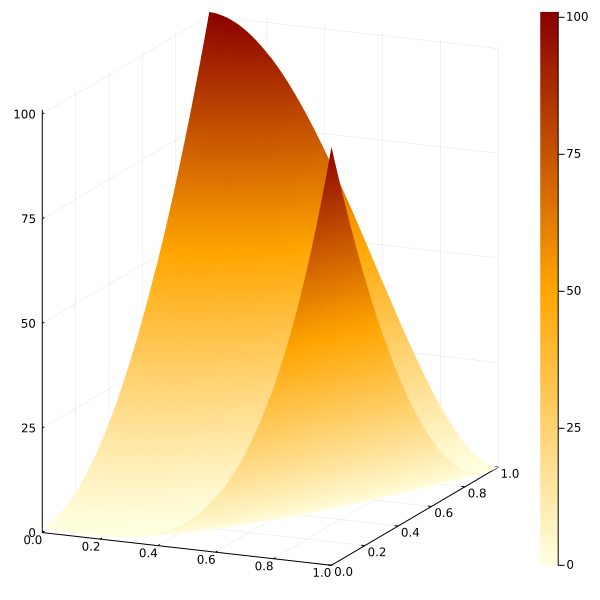

In [31]:
default(size=(600,600))
x, y = 0:0.01:1.0, 0:0.01:1.0
z = Surface((x,y)->rosenbrock([x,y]), x, y)
surface(x,y,z, linealpha = 0.3)

In [32]:
Plots.contour(x,y,z, linealpha = 0.1, levels=2500)

In [33]:
png("contoursRosenbrock")

In [41]:
sol, iter = steepestdescent(rosenbrock, rosenbrock_gradient, [0,0], 10.0, true, true)

0. x = [0, 0], f([0, 0]) = 1.0
1. x = [0.1612620227407261, 0.0], f([0.1612620227407261, 0.0]) = 0.7711096853441531
2. x = [0.16126202280695034, 0.02600544024872085], f([0.16126202280695034, 0.02600544024872085]) = 0.7034813943858886
3. x = [0.21133888041724883, 0.02600543876247529], f([0.21133888041724883, 0.02600543876247529]) = 0.6568010089605405
4. x = [0.21133888100318554, 0.04466412256994727], f([0.21133888100318554, 0.04466412256994727]) = 0.6219863606173075
5. x = [0.24508247498253186, 0.04466412279984179], f([0.24508247498253186, 0.04466412279984179]) = 0.5936204637173165
6. x = [0.2450824743849232, 0.06006541860916487], f([0.2450824743849232, 0.06006541860916487]) = 0.5699004704807902
7. x = [0.2711222718134955, 0.06006542082182948], f([0.2711222718134955, 0.06006542082182948]) = 0.5493311173278929
8. x = [0.2711222708981266, 0.0735072854577914], f([0.2711222708981266, 0.0735072854577914]) = 0.5312627439807038
9. x = [0.29257001561271645, 0.07350728639695933], f([0.29257001561

88. x = [0.5637055063787026, 0.31776390254482173], f([0.5637055063787026, 0.31776390254482173]) = 0.1903528851642664
89. x = [0.5670811022041661, 0.31776389896790874], f([0.5670811022041661, 0.31776389896790874]) = 0.18887578013987083
90. x = [0.5670811061399202, 0.32158098456016976], f([0.5670811061399202, 0.32158098456016976]) = 0.1874187686610363
91. x = [0.5703918675998588, 0.3215809817923052], f([0.5703918675998588, 0.3215809817923052]) = 0.1859813483317945
92. x = [0.5703918705066301, 0.325346889032092], f([0.5703918705066301, 0.325346889032092]) = 0.18456314492679302
93. x = [0.5736402603241066, 0.3253468866941144], f([0.5736402603241066, 0.3253468866941144]) = 0.18316368762260327
94. x = [0.5736402632112945, 0.32906315527968033], f([0.5736402632112945, 0.32906315527968033]) = 0.1817826251545356
95. x = [0.5768286022047667, 0.32906315251089274], f([0.5768286022047667, 0.32906315251089274]) = 0.18041951579613916
96. x = [0.5768286048682323, 0.33273124188066033], f([0.576828604868

176. x = [0.6715122879320504, 0.45092875953897815], f([0.6715122879320504, 0.45092875953897815]) = 0.10790417697964062
177. x = [0.6733161842647911, 0.4509287558622842], f([0.6733161842647911, 0.4509287558622842]) = 0.10731082819280631
178. x = [0.6733161890777579, 0.4533546970565887], f([0.6733161890777579, 0.4533546970565887]) = 0.10672231231868354
179. x = [0.6751007277612031, 0.4533546934609088], f([0.6751007277612031, 0.4533546934609088]) = 0.10613856466738773
180. x = [0.6751007318515787, 0.4557610036852685], f([0.6751007318515787, 0.4557610036852685]) = 0.10555953444338283
181. x = [0.6768662947996549, 0.455761000675426], f([0.6768662947996549, 0.455761000675426]) = 0.104985158960591
182. x = [0.6768662987470866, 0.45814799190373307], f([0.6768662987470866, 0.45814799190373307]) = 0.10441538888541015
183. x = [0.6786132571381945, 0.45814798891721614], f([0.6786132571381945, 0.45814798891721614]) = 0.10385016376515015
184. x = [0.6786132612495241, 0.46051596425787694], f([0.67861

264. x = [0.7364532022366673, 0.5423633196745706], f([0.7364532022366673, 0.5423633196745706]) = 0.06945691461130701
265. x = [0.7376594840689393, 0.542363319404554], f([0.7376594840689393, 0.542363319404554]) = 0.06913874405626466
266. x = [0.7376594843680497, 0.5441415157303816], f([0.7376594843680497, 0.5441415157303816]) = 0.06882254614203762
267. x = [0.7388563661217463, 0.5441415153415604], f([0.7388563661217463, 0.5441415153415604]) = 0.06850830219472998
268. x = [0.7388563672158199, 0.5459087330168845], f([0.7388563672158199, 0.5459087330168845]) = 0.06819599694371895
269. x = [0.740043976322651, 0.5459087322703645], f([0.740043976322651, 0.5459087322703645]) = 0.06788561240163589
270. x = [0.7400439772441988, 0.5476650898029054], f([0.7400439772441988, 0.5476650898029054]) = 0.06757713376701487
271. x = [0.7412224371432343, 0.5476650891013802], f([0.7412224371432343, 0.5476650891013802]) = 0.06727054324145736
272. x = [0.7412224388790682, 0.549410706196096], f([0.7412224388790

352. x = [0.7820283031043188, 0.611568266567989], f([0.7820283031043188, 0.611568266567989]) = 0.04751166064758272
353. x = [0.7829142115791345, 0.6115682666851358], f([0.7829142115791345, 0.6115682666851358]) = 0.04731844892325389
354. x = [0.7829142111891376, 0.6129546616752468], f([0.7829142111891376, 0.6129546616752468]) = 0.04712623970363435
355. x = [0.7837945426899662, 0.6129546618401578], f([0.7837945426899662, 0.6129546618401578]) = 0.04693502546464018
356. x = [0.7837945418553595, 0.6143338824171756], f([0.7837945418553595, 0.6143338824171756]) = 0.04674480013153411
357. x = [0.784669353572884, 0.6143338829937918], f([0.784669353572884, 0.6143338829937918]) = 0.04655555627183733
358. x = [0.7846693524396178, 0.6157059910116148], f([0.7846693524396178, 0.6157059910116148]) = 0.046367287778773816
359. x = [0.7855387011306229, 0.61570599167631], f([0.7855387011306229, 0.61570599167631]) = 0.04617998740135746
360. x = [0.7855387003039929, 0.6170710485455247], f([0.785538700303992

440. x = [0.8163912841908721, 0.6664947295577336], f([0.8163912841908721, 0.6664947295577336]) = 0.03371216052107712
441. x = [0.8170765610211917, 0.666494729313303], f([0.8170765610211917, 0.666494729313303]) = 0.03358628507216347
442. x = [0.817076561571851, 0.6676141082363024], f([0.817076561571851, 0.6676141082363024]) = 0.033460984326376855
443. x = [0.8177581455557039, 0.667614107950803], f([0.8177581455557039, 0.667614107950803]) = 0.033336254761450225
444. x = [0.8177581464504499, 0.6687283871896142], f([0.8177581464504499, 0.6687283871896142]) = 0.0332120931851758
445. x = [0.818436069022436, 0.6687283867791086], f([0.818436069022436, 0.6687283867791086]) = 0.03308849622418225
446. x = [0.8184360696267852, 0.6698376010130439], f([0.8184360696267852, 0.6698376010130439]) = 0.032965460812569694
447. x = [0.81911036117316, 0.6698376006613833], f([0.81911036117316, 0.6698376006613833]) = 0.03284298347111887
448. x = [0.8191103618932408, 0.6709417861194529], f([0.8191103618932408, 

528. x = [0.8434158764913244, 0.711350348787019], f([0.8434158764913244, 0.711350348787019]) = 0.024518587734986677
529. x = [0.8439637248380706, 0.7113503459637676], f([0.8439637248380706, 0.7113503459637676]) = 0.02443277493229108
530. x = [0.8439637288375411, 0.7122747821379697], f([0.8439637288375411, 0.7122747821379697]) = 0.02434731791828868
531. x = [0.8445089566809133, 0.712274779851146], f([0.8445089566809133, 0.712274779851146]) = 0.02426221463184357
532. x = [0.8445089604945109, 0.7131953909834191], f([0.8445089604945109, 0.7131953909834191]) = 0.024177463366501978
533. x = [0.8450515871613341, 0.7131953886704567], f([0.8450515871613341, 0.7131953886704567]) = 0.024093062185586912
534. x = [0.8450515909640354, 0.71411219776822], f([0.8450515909640354, 0.71411219776822]) = 0.024009009462780673
535. x = [0.8455916348854702, 0.7141121955455206], f([0.8455916348854702, 0.7141121955455206]) = 0.02392530330242065
536. x = [0.8455916387124625, 0.7150252259745824], f([0.845591638712

616. x = [0.8652674841522197, 0.748687823936185], f([0.8652674841522197, 0.748687823936185]) = 0.01815285082667469
617. x = [0.8657155364489985, 0.7486878223382702], f([0.8657155364489985, 0.7486878223382702]) = 0.018092467678600403
618. x = [0.8657155390507392, 0.7494633993700066], f([0.8657155390507392, 0.7494633993700066]) = 0.018032316452435877
619. x = [0.866161642263174, 0.7494633977700732], f([0.866161642263174, 0.7494633977700732]) = 0.01797239595865667
620. x = [0.8661616454165071, 0.7502360014960376], f([0.8661616454165071, 0.7502360014960376]) = 0.01791270515761981
621. x = [0.866605812304097, 0.7502359996689815], f([0.866605812304097, 0.7502359996689815]) = 0.017853242998967483
622. x = [0.866605815151842, 0.7510056439314196], f([0.866605815151842, 0.7510056439314196]) = 0.01779400855130713
623. x = [0.8670480573066781, 0.7510056422484399], f([0.8670480573066781, 0.7510056422484399]) = 0.017735000640941405
624. x = [0.8670480601023122, 0.7517723434976744], f([0.867048060102

704. x = [0.8832864473773815, 0.7801949555040414], f([0.8832864473773815, 0.7801949555040414]) = 0.013622053365798192
705. x = [0.8836590076315033, 0.7801949531471921], f([0.8836590076315033, 0.7801949531471921]) = 0.013578560896153724
706. x = [0.8836590122159873, 0.7808532580740638], f([0.8836590122159873, 0.7808532580740638]) = 0.01353522543856652
707. x = [0.8840300726936869, 0.780853255457645], f([0.8840300726936869, 0.780853255457645]) = 0.013492046352925514
708. x = [0.8840300766191581, 0.7815091833619677], f([0.8840300766191581, 0.7815091833619677]) = 0.01344902312896323
709. x = [0.8843996448095918, 0.7815091811329514], f([0.8843996448095918, 0.7815091811329514]) = 0.01340615495965859
710. x = [0.8843996485132739, 0.7821627448373284], f([0.8843996485132739, 0.7821627448373284]) = 0.013363441263858902
711. x = [0.8847677329303604, 0.782162742752735], f([0.8847677329303604, 0.782162742752735]) = 0.013320881320303941
712. x = [0.884767736791935, 0.7828139550697094], f([0.88476773

792. x = [0.8983629478450131, 0.8070559919183675], f([0.8983629478450131, 0.8070559919183675]) = 0.010330090370758951
793. x = [0.8986766518519782, 0.8070559901104353], f([0.8986766518519782, 0.8070559901104353]) = 0.010298200535580417
794. x = [0.8986766553152763, 0.8076197373596417], f([0.8986766553152763, 0.8076197373596417]) = 0.010266420178103619
795. x = [0.8989891742706771, 0.8076197353390958], f([0.8989891742706771, 0.8076197353390958]) = 0.010234748851640819
796. x = [0.8989891780818884, 0.8081815491625872], f([0.8989891780818884, 0.8081815491625872]) = 0.010203186144577155
797. x = [0.8993005179415113, 0.8081815470499706], f([0.8993005179415113, 0.8081815470499706]) = 0.010171731634651198
798. x = [0.8993005218707387, 0.8087414356708454], f([0.8993005218707387, 0.8087414356708454]) = 0.010140384895510517
799. x = [0.8996106886330236, 0.8087414335043567], f([0.8996106886330236, 0.8087414335043567]) = 0.010109145504899891
800. x = [0.8996106925080952, 0.8092994052592849], f([0.

880. x = [0.9111195100768912, 0.8301387714244787], f([0.9111195100768912, 0.8301387714244787]) = 0.007899741488981416
881. x = [0.9113862592787664, 0.8301387684888346], f([0.9113862592787664, 0.8301387684888346]) = 0.007876028751729356
882. x = [0.9113862647336358, 0.8306249337588636], f([0.9113862647336358, 0.8306249337588636]) = 0.007852394077867707
883. x = [0.9116520587123387, 0.8306249306953519], f([0.9116520587123387, 0.8306249306953519]) = 0.007828837159960864
884. x = [0.9116520643948138, 0.8311094968840079], f([0.9116520643948138, 0.8311094968840079]) = 0.007805357725708873
885. x = [0.9119169075919082, 0.8311094937758242], f([0.9119169075919082, 0.8311094937758242]) = 0.007781955487254845
886. x = [0.9119169132766969, 0.8315924673384932], f([0.9119169132766969, 0.8315924673384932]) = 0.007758630166716213
887. x = [0.9121808101427094, 0.8315924641572929], f([0.9121808101427094, 0.8315924641572929]) = 0.007735381452441146
888. x = [0.9121808159565267, 0.832073851689549], f([0.9

968. x = [0.9220087640563741, 0.8501001768411702], f([0.9220087640563741, 0.8501001768411702]) = 0.006082632884039428
969. x = [0.9222373692451884, 0.8501001721970868], f([0.9222373692451884, 0.8501001721970868]) = 0.006064800810642016
970. x = [0.9222373778500381, 0.8505217970781929], f([0.9222373778500381, 0.8505217970781929]) = 0.006047025403663261
971. x = [0.9224652006801186, 0.8505217923982927], f([0.9224652006801186, 0.8505217923982927]) = 0.006029306453700887
972. x = [0.9224652091684857, 0.8509420776078945], f([0.9224652091684857, 0.8509420776078945]) = 0.0060116437893106365
973. x = [0.9226922528370642, 0.8509420730746031], f([0.9226922528370642, 0.8509420730746031]) = 0.005994037199126726
974. x = [0.9226922611476706, 0.8513610241586341], f([0.9226922611476706, 0.8513610241586341]) = 0.005976486486483612
975. x = [0.9229185292187964, 0.8513610196582326], f([0.9229185292187964, 0.8513610196582326]) = 0.0059589914387207545
976. x = [0.9229185372911985, 0.8517786413888238], f([

([0.9255745569972949, 0.8566882745000424], [1.0 0.0 0.0; 0.7711096853441531 0.1612620227407261 0.0; … ; 0.005555311790944824 0.9255745493698055 0.8562862005552137; 0.005539146566168343 0.9255745569972949 0.8566882745000424])

Le minimiseur est situé en $(1,1)$. En effet,
$$
\nabla f(1,1) = \begin{pmatrix} 0 \\ 0 \end{pmatrix}
$$
et
$$
\nabla^2 f(1,1) =
\begin{pmatrix}
802 & -400 \\ -400 & 200
\end{pmatrix}
$$
Les déterminants des mineurs principaux sont positifs comme ils valent respectivement 802 et $802\times200-400^2= 400$, aussi la matrice hessienne est définie positif.

Cependant, la méthode de plus forte pente converge très lentement.

In [42]:
niter, d = size(iter)

(1001, 3)

In [43]:
iter[15:100]

86-element Vector{Float64}:
 0.45285317109452106
 0.44294683674908686
 0.43364967093169987
 0.4248824645510051
 0.4165975815103173
 0.4087389645403241
 0.40127211678545444
 0.3941558676722247
 0.38736439964092756
 0.3808665590438894
 0.3746424997444731
 0.3686680627004397
 0.36292764913520204
 ⋮
 0.1903528851642664
 0.18887578013987083
 0.1874187686610363
 0.1859813483317945
 0.18456314492679302
 0.18316368762260327
 0.1817826251545356
 0.18041951579613916
 0.17907402965776728
 0.17774575181160876
 0.176434371539964
 0.17513949845955692

In [44]:
#for i ∈ 1:niter-1
#    plot!(iter[i:i+1,2], iter[i:i+1,3], legend=false)
#end

┌ Info: Saved animation to 
│   fn = C:\Users\slash\OneDrive - Universite de Montreal\Git\optim\NLP\iterationsRosenbrock.gif
└ @ Plots C:\Users\slash\.julia\packages\Plots\YAlrZ\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\slash\\OneDrive - Universite de Montreal\\Git\\optim\\NLP\\iterationsRosenbrock.gif")
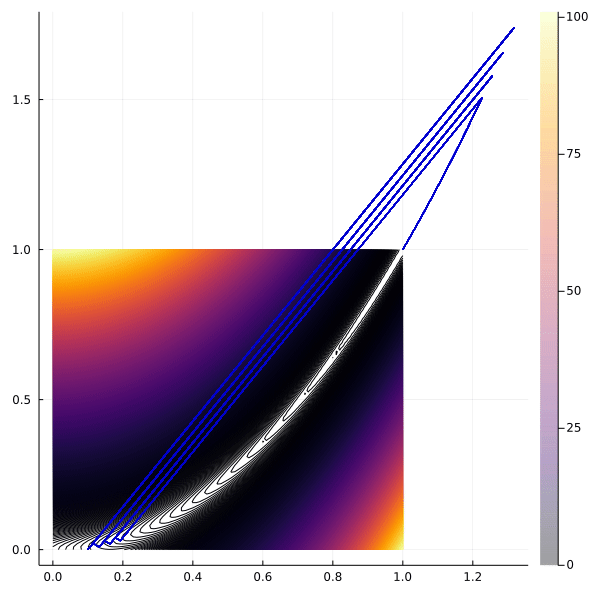

In [45]:
df = 2
anim = @animate for i = 1:df:niter+1-df
    plot!(iter[1:i,2], iter[1:i,3], legend=false, linecolor=:blue3)
end
 
gif(anim, "iterationsRosenbrock.gif", fps = 30)

In [ ]:
png("iteratesRosenbrock")

# Minimisation exacte ou approximative?

La minimisation exacte d'une fonction le long de la direction de recherche exige des hypothèses comme l'unimodalité ou la convexité, lesquelles ne sont pas nécessairement satisfaites. Il est plus pratique de miniser la fonction approximativement le long de la direction de recherche au mieux d'une marche arrière (backtracking). Ceci sera fait plus explicitement dans le bloc-notes sur le recherche linéaire.

Pour les fonctions non-convexes, une première approche consiste à fixer la longueur du pas.

In [ ]:
function batchdescent(f::Function, fprime::Function, x0, α::Float64, verbose::Bool = true,
                      record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end
    
    while ((k < maxiter) && (norm(grad) > tol))
        x = x-α*grad
        k += 1
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx")
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

Nous pouvons être proche de la solution si $\alpha$ est assez petit.

In [ ]:
sol, iter = batchdescent(f1, f1grad, [2.0,3.0], 0.1, true, true)

Mais si $\alpha$ est trop grand, cela ne fonctionne tout simplement pas!

In [ ]:
ol, iter = batchdescent(f1, f1grad, [2.0,3.0], 2.0, true, true)

Si $f \in C^1$, $f$ convexe, et $\nabla f(\cdot)$ est continue au send de Lipschitz, i.e. $\exists L >0$ tel que
$$
\forall x, y,\ \| \nabla f(x) - \nabla f(y) \|_2 \leq L \| x - y\|_2,
$$
nous pouvons retrouver la convergence en considérant une séquence décroissante de longueurs de pas $\alpha_k > 0$ satisfaisant
$$
\sum_{k = 1}^{+\infty} \alpha_k = +\infty,\qquad \sum_{k = 1}^{+\infty} \alpha_k^2 < +\infty.
$$
Exemple: $\alpha_k = \frac{\kappa}{k}$.

In [ ]:
function rbdescent(f::Function, fprime::Function, x0, α0::Float64, verbose::Bool = true,
                   record::Bool = false, tol::Float64 = 1e-7, maxiter::Int64 = 1000)

    function fsearch(α::Float64)
        return(f(x-α*grad))
    end

    x = x0
    k = 0
    α = α0

    grad = fprime(x)

    if (verbose || record)
        fx = f(x)
    end
    if (verbose)
        println("$k. x = $x, f($x) = $fx")
    end
    if (record)
        iterates = [ fx x' ]
    end
    
    while ((k < maxiter) && (norm(grad) > tol))
        k += 1
        α = α0/k 
        x = x-α*grad
        grad = fprime(x)       
        if (verbose || record)
            fx = f(x)
        end
        if (verbose)
            println("$k. x = $x, f($x) = $fx", ", α = ", α)
        end
        if (record)
            iterates = [ iterates; fx x' ]
        end
    end

    if (k == maxiter)
        println("WARNING: maximum number of iterations reached")
    end

    if (record)
        return x, iterates
    else
        return x
    end
end

In [ ]:
ol, iter = rbdescent(f1, f1grad, [2.0,3.0], 2.0, true, true)

In [ ]:
ol, iter = rbdescent(f1, f1grad, [10.0,10.0], 2.0, true, true)

In [ ]:
ol, iter = rbdescent(f1, f1grad, [100.0,100.0], 2.0, true, true)

In [ ]:
ol, iter = rbdescent(f1, f1grad, [100.0,100.0], 0.1, true, true)

Cette technique a été proposée par Robbins et Monro en 1951 dans le contexte de l'approximation stochastique, où la fonction objectif est
$$
f(x) = E[g(x,\xi)]
$$
et à chaque itération, le prochain itéré est calculé comme
$$
x_{k+1} = x_k - \alpha_k \nabla g(x_k,\xi_k)
$$
où $\xi_k$ est tiré de la distribution de $\xi$.

Cette technique, de même que certaines extensions (mini-lots, gradient stochastique moyen, etc.) est toujours très populaire en apprentissage automatique.